# Day 21

This is a full solution to day 21 part 2 that makes almost no assumptions about the particular shape of the input. It only assumes that the difference series of the function from step number to number of squares reached is eventually periodic. Since the grid is repeated, this probably should (?) happen for all inputs eventually.

The idea is to just think of this as a black box function - we calculate the first 100-200 values for it with code, then just analyze it to extract the period and amplitude. There are probably better ways to do this.


# Solution

In [39]:
#Imports and helper fn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import itertools
import collections

def sliding_window(iterable, n):
    # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = collections.deque(itertools.islice(it, n-1), maxlen=n)
    for x in it:
        window.append(x)
        yield tuple(window)

**Set input_set below to "sample" or "real" here, then Run All cells.**



In [40]:
input_set = "real"

In [42]:
import ast
def parse_tups(contents):
  return ast.literal_eval(contents)

input_tups = None
if input_set == "sample":
  f = open('./num_reached.sample.txt','r')
  input_tups = parse_tups(f.read())
elif input_set == "real":
  f = open('./num_reached.realinput.txt','r')
  input_tups = parse_tups(f.read())
xs = [a[0] for a in input_tups]
ys = [a[1] for a in input_tups]

plt.rcParams["figure.figsize"] = (15,5)

Lets try to predict the function based on its values alone. First we plot the function - it looks well behaved.

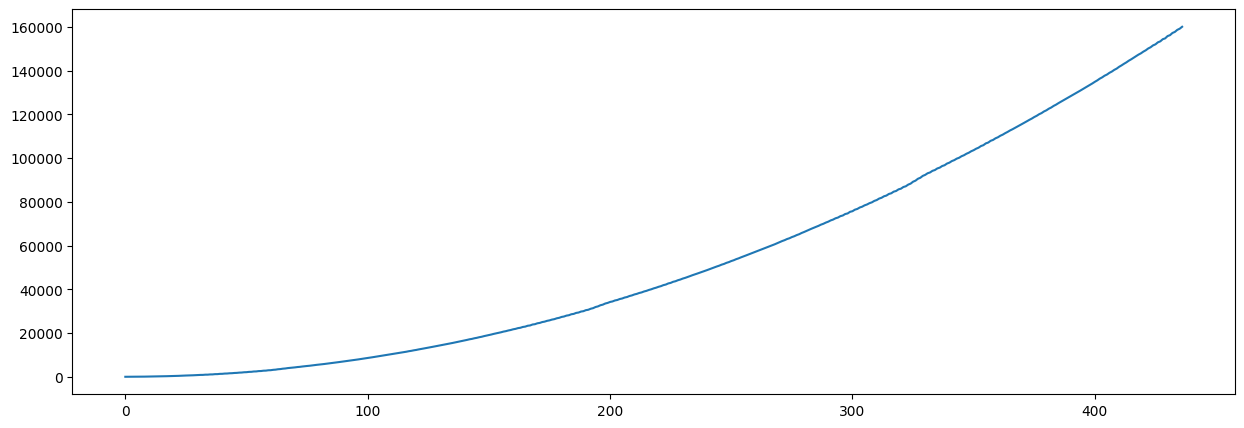

In [ ]:
plt.plot(xs,ys)

In [55]:
diffs = [ys]
prev = ys
for i in range(10):
  diff = [t[1] - t[0] for t in sliding_window(prev,2)]
  diffs.append(diff)
  prev = diff

This is a plot of the differences between consecutive elements, iterated. So the 2nd differences onward seem to flatten out.

For a 2nd degree polynomial, the differences would be 0. But for a combination like this, they seem to become constant except for scaling up.

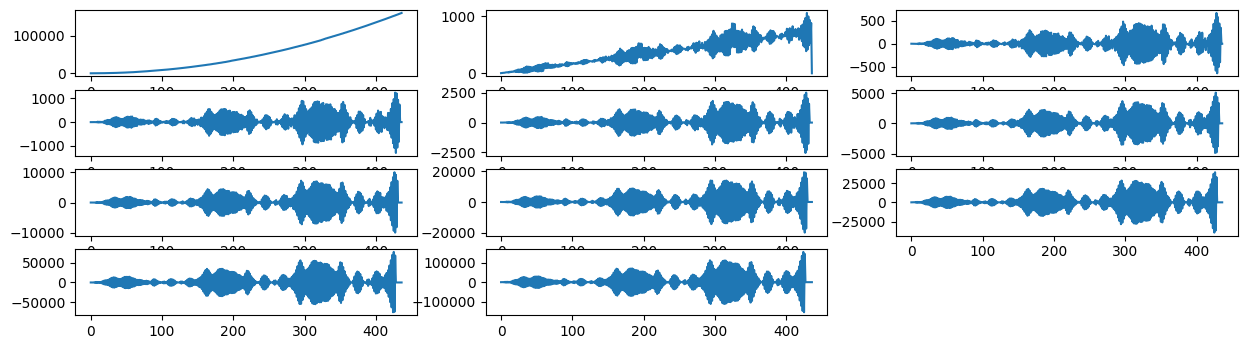

In [44]:
for (i,diff) in enumerate(diffs):
  plt.subplot(5,3,i+1)
  ys_plot = np.pad(diff, (0,len(xs)-len(diff)), 'constant') #DIFF[0] = Y1 - Y0, DIFF[1] = Y2 - Y1, ... DIFF[N-1] = YN - YN-1, DIFF[N] is padded to be 0 so we can graph
  plt.plot(xs,ys_plot)

But regardless, we can see the first derivative is pseudo-periodic with increasing amplitude. If we can find the period and amplitudes, we can solve the function

Some ideas and corresponding graphs:

1. We can use a log-log plot to confirm its a polynomial (right?)

2. Using `np.gradient` - is this like consecutive differences above?

3. Can FFT help find the period?

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


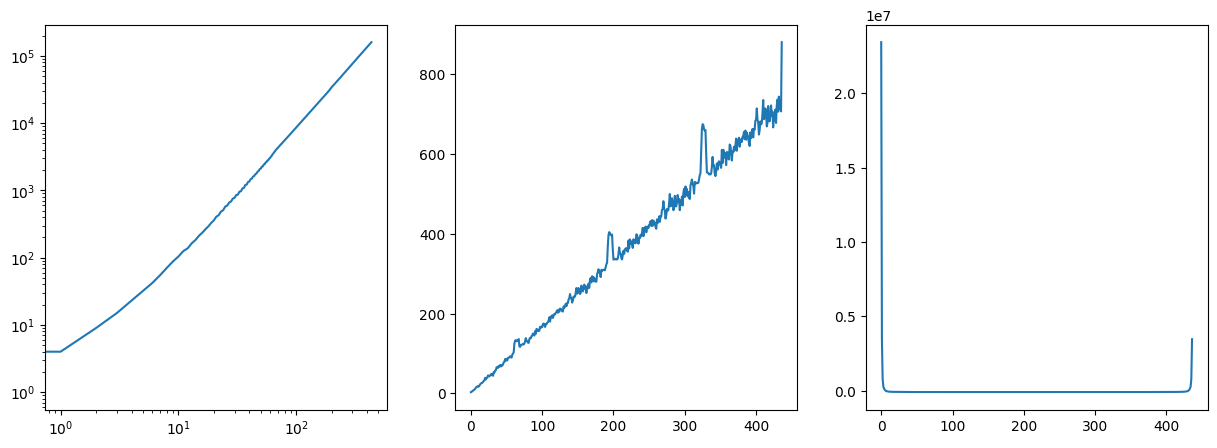

In [45]:
plt.subplot(1,3,1)
plt.loglog(xs,ys)
plt.subplot(1,3,2)
plt.plot(xs,np.gradient(ys))
plt.subplot(1,3,3)
plt.plot(xs, np.fft.fft(ys))

Lets try to find the period by looking more closely

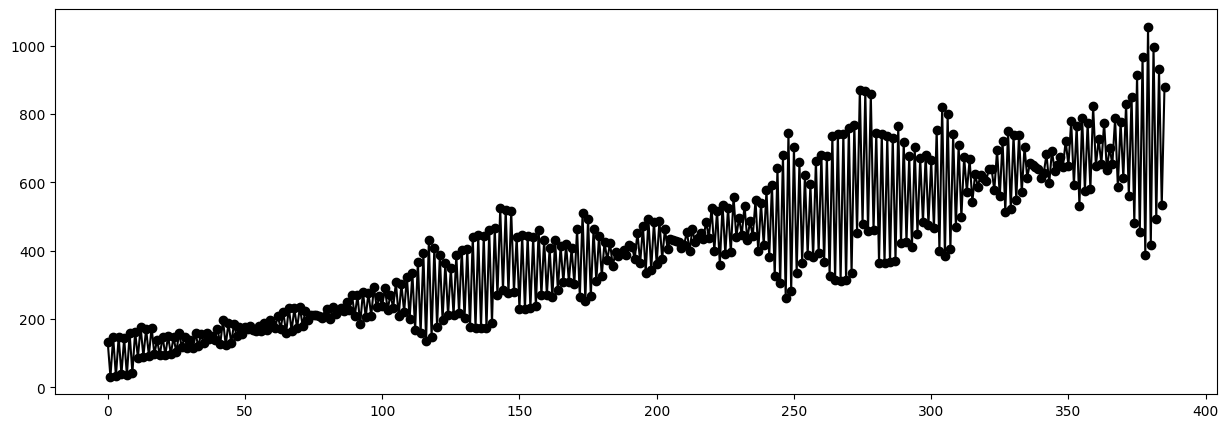

In [ ]:
yd = diffs[1]
lateryds = yd[20:] if input_set == "sample" else yd[50:]
plot_part = lateryds[:30] if input_set == "sample" else lateryds[:400]
plt.plot(plot_part, '-ok')

By manual inspection, we can see the pseudo-period is 11 for the sample or 131 for the real input. This is also the size of the grid!

All the graphs below line up beautifully :) If the period was wrong, they would not be lines.

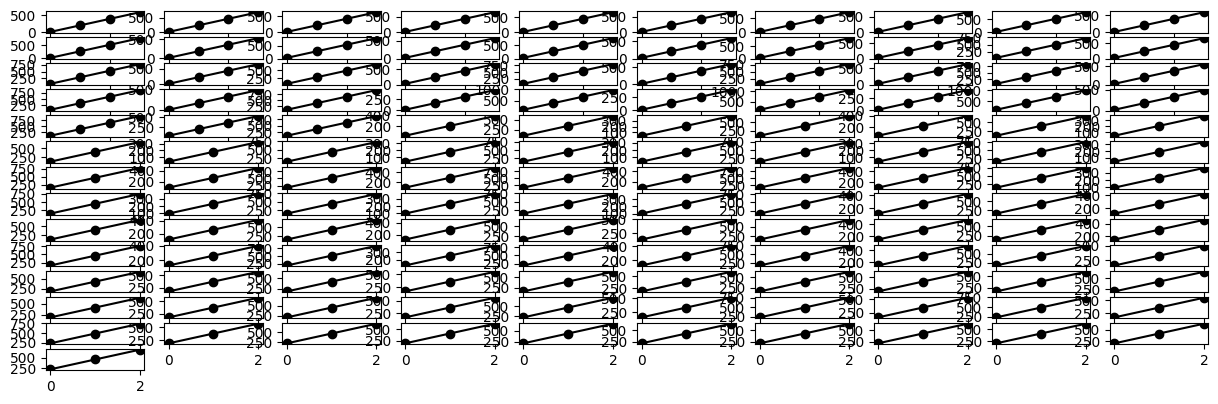

In [46]:
if input_set == "sample":
  period = 11
  (nr,nc) = (4,3)
elif input_set == "real":
  period = 131
  (nr,nc) = (15,10)

periodic_parts = []
for start in range(period):
  periodic = yd[start::period]
  periodic_parts.append(periodic)
  plt.subplot(nr,nc,start+1)
  plt.plot(periodic, '-ok')

In [47]:
# They may not line up perfectly though. They take a maximum of 5 cycles to settle into a regular rhythm
periodic_incrs = []
for i in range(period):
  print(f"\nseq {i}", end="\t")
  for k in range(len(periodic_parts[i])-1):
    print(periodic_parts[i][k+1] - periodic_parts[i][k],end=",")
  d1 = periodic_parts[i][-1] - periodic_parts[i][-2]
  d2 = periodic_parts[i][-2] - periodic_parts[i][-3]
  assert d1 == d2
  periodic_incrs.append(d1)


seq 0	198,198,198,
seq 1	229,229,229,
seq 2	209,209,209,
seq 3	214,214,214,
seq 4	222,222,222,
seq 5	212,212,212,
seq 6	236,236,236,
seq 7	211,211,211,
seq 8	254,254,254,
seq 9	192,192,192,
seq 10	248,248,248,
seq 11	173,173,173,
seq 12	254,254,254,
seq 13	185,185,185,
seq 14	248,248,248,
seq 15	186,186,186,
seq 16	264,264,264,
seq 17	207,207,207,
seq 18	230,230,230,
seq 19	208,208,208,
seq 20	242,242,242,
seq 21	205,205,205,
seq 22	215,215,215,
seq 23	210,210,210,
seq 24	240,240,240,
seq 25	189,189,189,
seq 26	237,237,237,
seq 27	196,196,196,
seq 28	253,253,253,
seq 29	180,180,180,
seq 30	258,258,258,
seq 31	157,157,157,
seq 32	273,273,273,
seq 33	148,148,148,
seq 34	288,288,288,
seq 35	125,125,125,
seq 36	312,312,312,
seq 37	135,135,135,
seq 38	293,293,293,
seq 39	157,157,157,
seq 40	273,273,273,
seq 41	168,168,168,
seq 42	258,258,258,
seq 43	176,176,
seq 44	245,245,
seq 45	169,169,
seq 46	275,275,
seq 47	173,173,
seq 48	277,277,
seq 49	164,164,
seq 50	271,271,
seq 51	147,147,
seq 5

With all this, we should be able to predict the value of ydiff (the first differences of y) for any given x.. lets test that. Note that the sequences don't have regular increments at the beginning. They all reach the regular increment by the 5th element. So we store the first few values (~55) and use the periodicity to compute the rest.

We can test the calculations against our input data


In [48]:
BASE_NUM = 66 if input_set == "sample" else 131
def yd_at_x(x):
  if x < BASE_NUM:
    return yd[x]
  else:
    referrents = range(BASE_NUM-period,BASE_NUM)
    i = x % period
    base = yd[referrents[i]]
    return base + periodic_incrs[i] * ((x-referrents[i]) // period)

mine = [yd_at_x(j) for j in range(len(ys)-1)]
expected = [yd[j] for j in range(len(ys)-1)]
print(mine)
print(expected)
assert(mine == expected)
print("Calculations match!!")

[3, 5, 6, 8, 9, 10, 13, 16, 17, 16, 21, 13, 26, 20, 29, 23, 30, 27, 36, 30, 48, 22, 56, 23, 67, 20, 65, 25, 71, 21, 77, 11, 95, 10, 104, 12, 119, 12, 116, 21, 113, 29, 106, 35, 104, 42, 113, 46, 126, 38, 134, 31, 147, 32, 148, 38, 144, 35, 158, 42, 163, 87, 177, 90, 171, 93, 175, 97, 139, 94, 148, 95, 150, 98, 147, 103, 158, 119, 146, 115, 139, 114, 158, 120, 156, 131, 158, 142, 150, 140, 172, 126, 197, 123, 189, 130, 184, 150, 178, 156, 176, 171, 179, 167, 166, 181, 166, 188, 169, 196, 185, 175, 210, 171, 220, 158, 233, 165, 231, 173, 235, 181, 223, 196, 213, 212, 211, 210, 202, 208, 228, 201, 234, 215, 222, 231, 222, 249, 227, 271, 208, 269, 186, 280, 205, 277, 209, 294, 234, 266, 238, 290, 227, 271, 233, 307, 209, 302, 221, 324, 201, 335, 168, 368, 158, 392, 137, 431, 147, 409, 178, 386, 197, 364, 211, 349, 211, 388, 219, 403, 202, 405, 178, 441, 173, 445, 175, 443, 174, 459, 188, 466, 270, 524, 284, 519, 275, 517, 279, 441, 229, 445, 229, 442, 232, 439, 237, 461, 270, 432, 270, 408

Now we can calculate $y_d(i) = y(i+1) - y(i)$ for any $i$. How do we calculate $y(x)$ for arbitrary $x$?

Sum $y_d(x-1) + y_d(x-2) + \cdots + y_d(0) = y(x) - y(x-1) + y(x-1) - y(x-2) + y(x-2) - y(x-3) ... -y(1) + y(1) - y(0) = y(x) - y(0)$

i.e $y(x) = \sum_{i=0}^{x-1} y_d(i) + y(0)$

In [49]:
TARGET_NUM = 26501365
def solve(x):
  sum = 0
  for j in range(0,x):
    sum += yd_at_x(j)
  return sum + 1

if input_set == "sample":
  assert(solve(6) == 16)
  assert(solve(10) == 50)
  assert(solve(50) == 1594)
  assert(solve(100) == 6536)
  assert(solve(500) == 167004)
  assert(solve(1000) == 668697)
  assert(solve(5000) == 16733044)
  print("Tests passed!")
elif input_set == "real":
  ans = solve(TARGET_NUM)
  print(f"Answer = {ans}")
  assert(ans == 590104708070703)

Answer = 590104708070703




------




## Detours



Fitting a polynomial directly to y doesn't work - this makes sense becuase its definitely NOT a polynomial unless picked at periodic points.


In [50]:
import numpy
polys = []
for d in range(2,5):
  poly,residuals,rank,singular_vals,rcond = numpy.polyfit(xs,ys,2,full=True)
  print(poly)
  print(residuals)
  polys.append(poly)

[  0.83868932   1.98447604 -27.29037714]
[11522630.3499776]
[  0.83868932   1.98447604 -27.29037714]
[11522630.3499776]
[  0.83868932   1.98447604 -27.29037714]
[11522630.3499776]


In [51]:
polys

[array([  0.83868932,   1.98447604, -27.29037714]),
 array([  0.83868932,   1.98447604, -27.29037714]),
 array([  0.83868932,   1.98447604, -27.29037714])]

In [52]:
for (i,poly) in enumerate(polys):
  print(poly)
  eval_at = [ 0,1,2,3,10]
  for x in eval_at:
    v = numpy.polyval(poly, x)
    print(f"{i+1}: p{x} = {v}")
  # print(numpy.po)
  # print(poly[1], poly[2], poly[3], poly[10])



[  0.83868932   1.98447604 -27.29037714]
1: p0 = -27.290377141284992
1: p1 = -24.467211786031193
1: p2 = -19.966667793388424
1: p3 = -13.788745163356687
1: p10 = 76.4233150937566
[  0.83868932   1.98447604 -27.29037714]
2: p0 = -27.290377141284992
2: p1 = -24.467211786031193
2: p2 = -19.966667793388424
2: p3 = -13.788745163356687
2: p10 = 76.4233150937566
[  0.83868932   1.98447604 -27.29037714]
3: p0 = -27.290377141284992
3: p1 = -24.467211786031193
3: p2 = -19.966667793388424
3: p3 = -13.788745163356687
3: p10 = 76.4233150937566


In [53]:
import scipy
import numpy as np
def exp_fn(x, a, b, c):
  return a*np.exp(b*x) + c

def poly3(x, a, b, c):
  return a*x**2 + b*x + c

xfs = [float(x) for x in xs][0:10]
yfs = [float(y) for y in ys][0:10]
p0 = (1,1,0) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(exp_fn, xfs, yfs, p0)
(a,b,c) = params
# print(params)
# print(cv)

p0_2 = (1,0,0)
p2, cv2 = scipy.optimize.curve_fit(poly3, xfs, yfs, p0_2)
(pa,pb,pc) = p2
print(cv2)

eval_at = [ 0,1,2,3,10]
for x in eval_at:
  v1 = exp_fn(x,a,b,c)
  v2 = poly3(x,pa,pb,pc)
  print(f"{x} = {v} = {v2}")

[[ 0.00115891 -0.0104302   0.01390693]
 [-0.0104302   0.10128879 -0.15853897]
 [ 0.01390693 -0.15853897  0.3782684 ]]
0 = 76.4233150937566 = 1.5363636363669881
1 = 76.4233150937566 = 4.124242424249238
2 = 76.4233150937566 = 8.446969696979394
3 = 76.4233150937566 = 14.504545454557459
10 = 76.4233150937566 = 105.48333333334529
